# 1)- Import key Modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [2]:
# modules for basic data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import math
import numpy as np

In [3]:
# for text data
from nltk.corpus import stopwords
# for data preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

In [4]:
# for ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE # for class imbalance
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib, sklearn, mlxtend

Software,Version
Python,3.7.7 64bit [MSC v.1916 64 bit (AMD64)]
IPython,7.13.0
OS,Windows 10 10.0.17763 SP0
pandas,1.0.3
numpy,1.18.1
nltk,3.5
seaborn,0.10.1
matplotlib,3.1.3
sklearn,0.23.1
mlxtend,0.17.2


# 2)- Loading Data

### 2a. Loading 1st data file

In [6]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training/training_variants')
data_variants.shape

(3321, 4)

In [7]:
data_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


- ID : row id used to link the mutation to the clinical evidence
- Gene : the gene where this genetic mutation is located
- Variation : the aminoacid change for this mutations
- Class : class value 1-9, this genetic mutation has been classified on

In [8]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [9]:
data_variants.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

### 2b. Loading 2nd dataset

In [10]:
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_text.shape

(3321, 2)

In [11]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [12]:
data_text.isnull().sum()

ID      0
TEXT    5
dtype: int64

we have few missing values in Text column

In [13]:
data_text[data_text.TEXT.isnull()]

,ID,TEXT
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


These are the exact sample where we have missing data

### 2c. Merge datasets

In [14]:
df_merge=pd.merge(data_variants, data_text, on='ID')
df_merge.shape

(3321, 5)

In [15]:
df_merge.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


### 2d.Checking target variable

In [16]:
df_merge.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [17]:
df_merge.Class.nunique()

9

In [18]:
df_merge.Class.value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

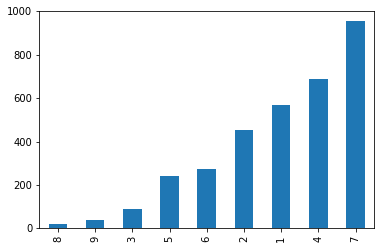

In [19]:
df_merge.Class.value_counts().sort_values().plot(kind="bar")

# 3)- Data Preprocessing

### 3a. Treating missing values

In [20]:
df_merge[df_merge.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


**imputing values by merging with Gene and Variation features**

In [21]:
df_merge.loc[df_merge['TEXT'].isnull(),'TEXT']=df_merge['Gene'] +' '+df_merge['Variation']

In [22]:
df_merge.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         0
dtype: int64

In [23]:
df_merge.TEXT[1109]

'FANCA S1088F'

### 3b.checking before clean

size of dataset

In [24]:
df_merge['TEXT']= df_merge['TEXT'].astype(str)

In [25]:
# checking length of text
df_merge['TEXT'].apply(lambda x: len(x.split(' '))).sum()

31796554

### 3c.Cleaning text data

In [26]:
stop_words = set(stopwords.words('english'))

In [27]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        df_merge[col][ind] = string

In [28]:
for index, row in df_merge.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [29]:
# after cleaning
df_merge['TEXT'].apply(lambda x: len(x.split(' '))).sum()

22773623

In [30]:
31796554-22773623

9022931

### 3d.Creating train, test & validation dataset

One more round of cleaning, we want to make sure that all spaces in Gene and Variation features are replaced by "_"

In [31]:
df_merge['Gene'] = df_merge.Gene.str.replace('\s+' , '_')
df_merge['Variation'] = df_merge.Variation.str.replace('\s+' , '_')

In [32]:
df_merge[40:50]

,ID,Gene,Variation,Class,TEXT
40,40,DICER1,D1810A,4,human dicer contains two rnase iii domains rna...
41,41,DICER1,Truncating_Mutations,1,mesenchymal cell populations contribute microe...
42,42,DICER1,E1705K,4,sex cord stromal tumors germ cell tumors accou...
43,43,DICER1,Deletion,1,mesenchymal cell populations contribute microe...
44,44,PTPRT,T1365M,4,tyrosine phosphorylation regulated protein tyr...
45,45,PTPRT,V648G,1,receptor protein tyrosine phosphatase ptprt pt...
46,46,PTPRT,T844M,4,introduction preceding hematologic disorders d...
47,47,PTPRT,A707T,1,receptor protein tyrosine phosphatase ptprt pt...
48,48,PTPRT,Promoter_Hypermethylation,4,metastasis leading cause death gastric carcino...
49,49,PTPRT,R1343L,4,tyrosine phosphorylation regulated protein tyr...


In [33]:
# differenciating target variable
y_true= df_merge['Class'].values

In [34]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(df_merge, y_true, stratify=y_true, test_size=0.2)

In [35]:
X_train.head(2)

,ID,Gene,Variation,Class,TEXT
1146,1146,MET,E168D,7,recurrent metastatic head neck cancer remains ...
3058,3058,KIT,T574insTQLPYD,2,gastrointestinal stromal tumors gist activatin...


In [36]:
test_df.head(2)

,ID,Gene,Variation,Class,TEXT
2927,2927,NFE2L2,G31V,7,cancer genome characterization efforts provide...
396,396,TP53,R175H,4,tumor suppressor p53 dependent apoptosis thoug...


In [37]:
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [38]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [39]:
cv_df.head(2)

,ID,Gene,Variation,Class,TEXT
20,20,CBL,H94Y,6,abstract background non small cell lung cancer...
812,812,ERCC2,V536M,1,increasing application gene panels familial ca...


### 3e.distribution of data
Let's look at the distribution of data in train, test and validation set.

In [40]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [41]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

In [42]:
test_class_distribution

1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64

In [43]:
cv_class_distribution

1     91
2     72
3     14
4    110
5     39
6     44
7    153
8      3
9      6
Name: Class, dtype: int64

### 3f.Visualize distribution

**Visualizing for train class distrubution**

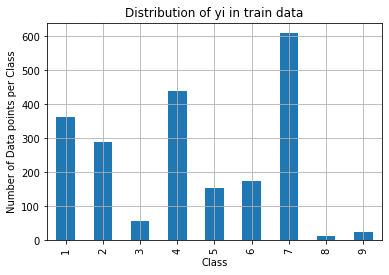

In [44]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [45]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


**Visualizing for test class distrubution**

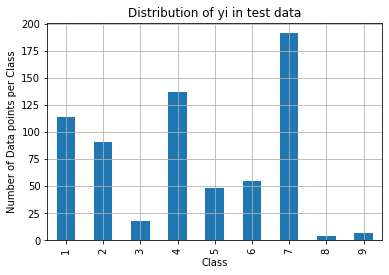

In [46]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [47]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


**visualize for cross validation set**

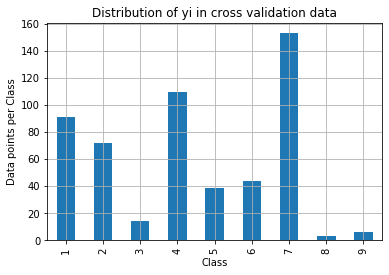

In [48]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [49]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


# 4)-Building a Random model

In [50]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

### 4a.For Cross validation

In [51]:
#we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.4158151242188177


It means that this is our comparison model. If we get a model with higher value of logloss then it is even worse than this given model and hence, it cannot be trusted at all

### 4b. For Test-Set

In [52]:
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.46914122047248


In [53]:
# for prob. of each class
test_predicted_y[:5]

array([[0.14850029, 0.12328866, 0.08138521, 0.20144431, 0.18061395,
        0.08528052, 0.11795241, 0.06112507, 0.00040958],
       [0.02078463, 0.22268562, 0.2647754 , 0.16399417, 0.08760399,
        0.13111658, 0.03274317, 0.05390403, 0.02239241],
       [0.18198054, 0.21517628, 0.11668318, 0.18493711, 0.05546566,
        0.00659964, 0.13761188, 0.0593294 , 0.04221631],
       [0.09618969, 0.14051172, 0.11380366, 0.14718011, 0.11863341,
        0.08106817, 0.0171486 , 0.17677182, 0.10869283],
       [0.01702736, 0.10473089, 0.13786738, 0.11169452, 0.15503646,
        0.17900656, 0.04173767, 0.07551547, 0.17738368]])

In [54]:
# convert this probability into class_prob 
predicted_y =np.argmax(test_predicted_y, axis=1)

In [55]:
predicted_y[:50]

array([3, 2, 1, 7, 5, 6, 3, 7, 3, 4, 1, 2, 1, 0, 2, 8, 4, 7, 2, 4, 7, 6,
       4, 1, 6, 8, 4, 6, 0, 5, 6, 6, 6, 2, 4, 1, 4, 3, 3, 5, 2, 8, 7, 8,
       8, 8, 2, 1, 4, 1], dtype=int64)

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [56]:
predicted_y = predicted_y + 1
predicted_y[:50]

array([4, 3, 2, 8, 6, 7, 4, 8, 4, 5, 2, 3, 2, 1, 3, 9, 5, 8, 3, 5, 8, 7,
       5, 2, 7, 9, 5, 7, 1, 6, 7, 7, 7, 3, 5, 2, 5, 4, 4, 6, 3, 9, 8, 9,
       9, 9, 3, 2, 5, 2], dtype=int64)

### 4c.Confusion Matrix

In [57]:
y_test[:10]

array([7, 4, 4, 7, 6, 4, 4, 2, 6, 5], dtype=int64)

In [58]:
C = confusion_matrix(y_test, predicted_y)

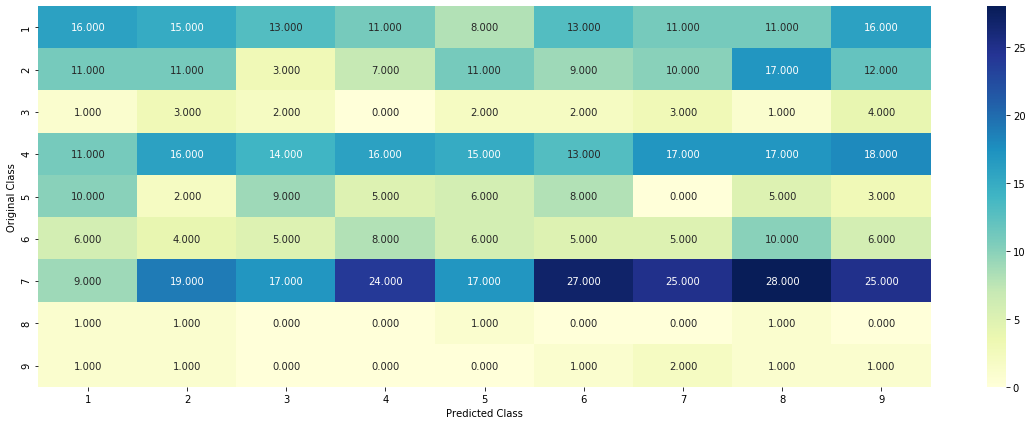

In [59]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### 4.d.Precision matrix

In [60]:
P =(C/C.sum(axis=0))

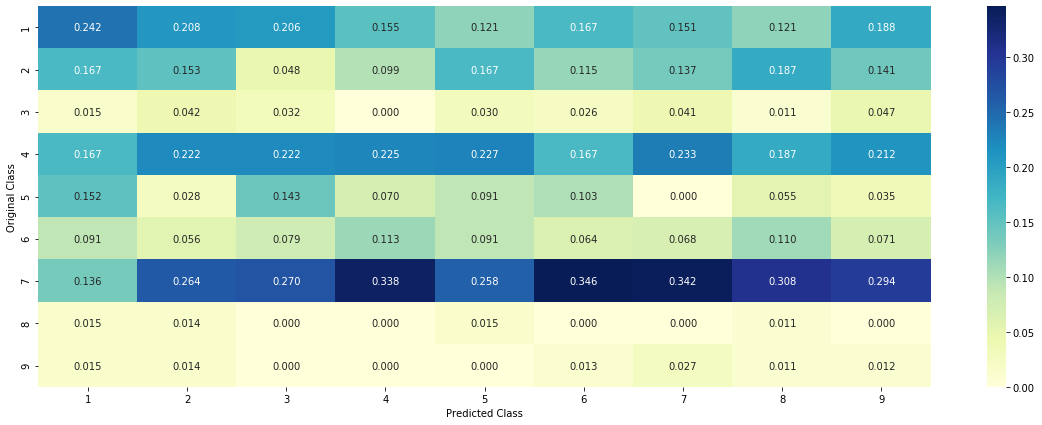

In [61]:
plt.figure(figsize=(20,7))
sns.heatmap(P, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

- Read them vertically for given values i.e row vice
- Of all the points which are predicted in your class 1 , 24.2% actually belongs to class 1
- Of all the points which are predicted in class 1 , 16.7% actually belongs to class 6.

### 4.e.Recall Matrix

In [62]:
A =(((C.T)/(C.sum(axis=1))).T)

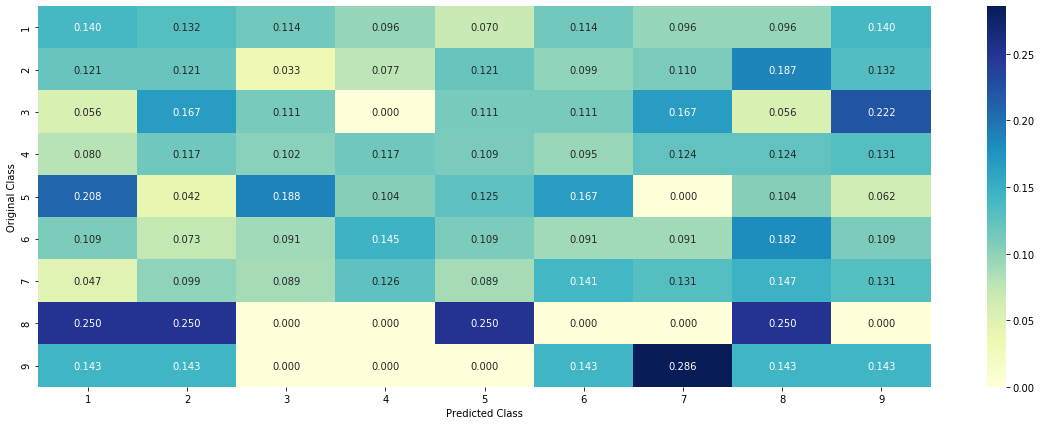

In [63]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

- Read them on horizontal way i.e column vise
- Of all the points which actually belongs to class 1, only 14% predicted to be in class 1.
- Of all the points which actually belongs to class 1, only 12.1% predicted to be in class 2.